# NBE-E4250 - Mapping, Decoding and Modeling the Human Brain D
---
## Table of Contents:
* ### [Project Work 1](#project1)
* ### [Project Work 2](#project2)
* ### [Project Work 3](#project3)
* ### [Project Work 4](#project4)

---
# Project Work 1 <a class="anchor" id="project1"></a>
---
## Installing Packages

In [1]:
%%capture
!pip install pytest
!pip install nibabel

## Importing Packages

In [2]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
import statsmodels.api as sm
import scipy.io
import scipy.stats as stats
%matplotlib inline

plt.rcParams["figure.figsize"] = (8, 5)

## Data Preparation

In [3]:
s1_img = nib.load("subj1/bold.nii.gz")
s1_data = s1_img.get_fdata()
print(s1_data.shape)

@widgets.interact(slice_no=(0, s1_data.shape[1] - 1))
def plot_data(slice_no=1):
    plt.imshow(s1_data[:, :, slice_no, 1])
    plt.title(slice_no)
    plt.show()

(40, 64, 64, 1452)


interactive(children=(IntSlider(value=1, description='slice_no', max=63), Output()), _dom_classes=('widget-int…

In [4]:
anat = nib.load("subj1/anat.nii.gz").get_fdata()
print(anat.shape)

@widgets.interact(slice_no=(0, anat.shape[2] - 1))
def plot_data(slice_no=128+64):
    plt.imshow(anat[:, :, slice_no])
    plt.title(slice_no)
    plt.show()

(124, 256, 256)


interactive(children=(IntSlider(value=192, description='slice_no', max=255), Output()), _dom_classes=('widget-…

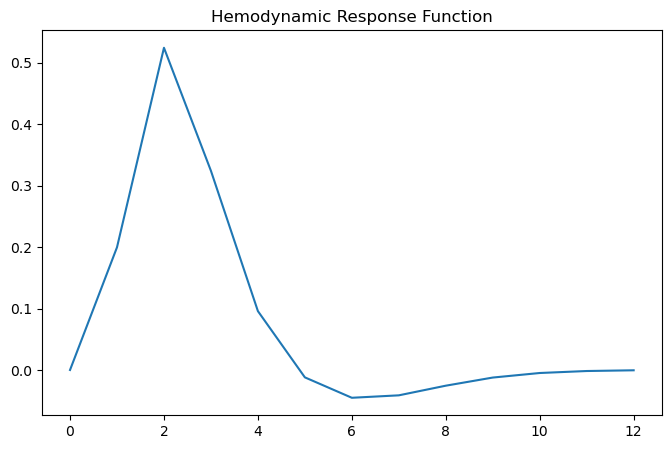

In [5]:
hrf_signal = scipy.io.loadmat("hrf.mat")["hrf_sampled"].flatten()
plt.title("Hemodynamic Response Function")
plt.plot(hrf_signal)

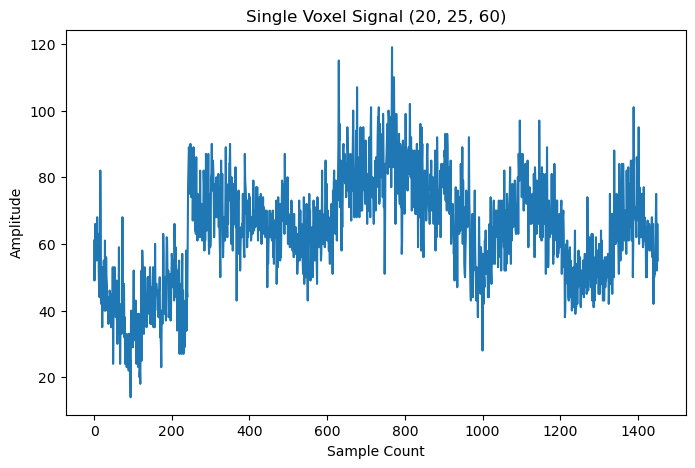

In [6]:
plt.plot(s1_data[20, 25, 60, :])
plt.title("Single Voxel Signal (20, 25, 60)")
plt.ylabel("Amplitude")
plt.xlabel("Sample Count")
plt.show()

## HRF \& GLM

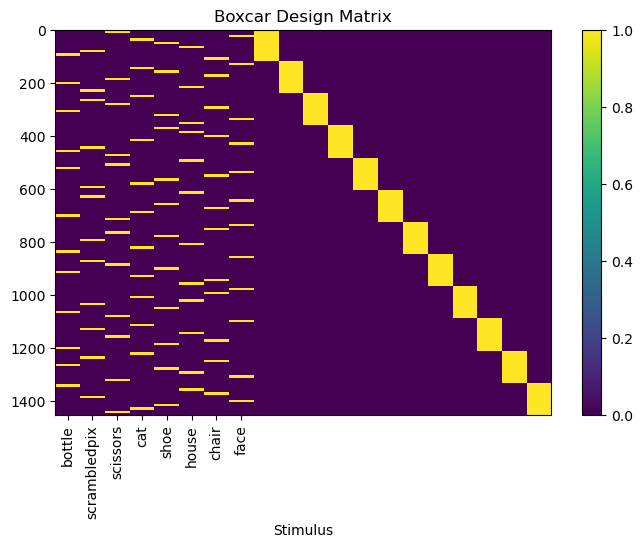

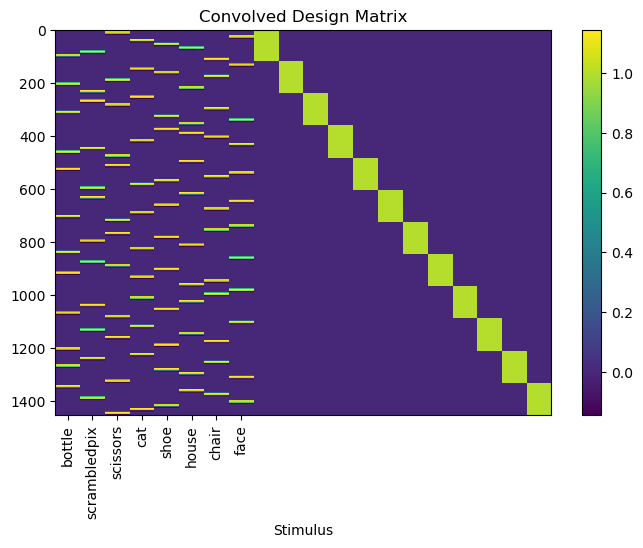

In [5]:
hrf_signal = scipy.io.loadmat("hrf.mat")["hrf_sampled"].flatten()

#convolve boxcar with hrf_signal
with open("subj1/labels.txt") as f:
    lines = f.readlines()[1:]
    labels = list(set([line.split()[0] for line in lines]) - set(["rest"]))
    design_matrix = np.zeros((len(lines), len(labels) + 12))
    for i, line in enumerate(lines):
        design_matrix[i, len(labels) + int(line.split()[1])] = 1.
        if line.split()[0] == "rest":
            continue
        design_matrix[i, labels.index(line.split()[0])] = 1.
        
    plt.imshow(design_matrix, aspect="auto", interpolation="none")
    plt.xticks(np.arange(len(labels)), labels, rotation="vertical")
    plt.xlabel("Stimulus")
    plt.title("Boxcar Design Matrix")
    plt.colorbar()
    plt.show()
    
    for col in range(design_matrix.shape[1] - 12):
        design_matrix[:, col] = np.convolve(design_matrix[:, col], hrf_signal)[:len(lines)]
        
    plt.imshow(design_matrix, aspect="auto", interpolation="none")
    plt.xticks(np.arange(len(labels)), labels, rotation="vertical")
    plt.xlabel("Stimulus")
    plt.title("Convolved Design Matrix")
    plt.colorbar()
    plt.show()

In [6]:
def fit_glm_vec(s_data, X=design_matrix, labels=labels, stimulus="house"):
    t_statistics = np.zeros(s_data.shape[:-1])
    c = np.zeros(len(labels) + 12)
    c[labels.index(stimulus)] = 1.
    
    s_data_2d = s_data.reshape(-1, s_data.shape[-1])
    betas_2d = np.linalg.pinv(X.T @ X) @ X.T @ s_data_2d.T
    betas = np.reshape(betas_2d, (c.size, 
                                  s_data.shape[0], 
                                  s_data.shape[1], 
                                  s_data.shape[2]))
    cov_X = np.linalg.pinv(X.T @ X)
    err_var = np.var(X @ betas_2d - s_data_2d.T)
    num = c @ betas_2d
    denom = np.sqrt(err_var * c @ cov_X @ c.T)
    t_statistics = np.reshape(num / denom, s_data.shape[:-1])
    
                
    return t_statistics, betas

In [9]:
t_dict = dict() 
betas_dict = dict()

for label in labels:
    t_dict[label], betas_dict[label] = fit_glm_vec(s1_data, stimulus=label)

## Result Visualization

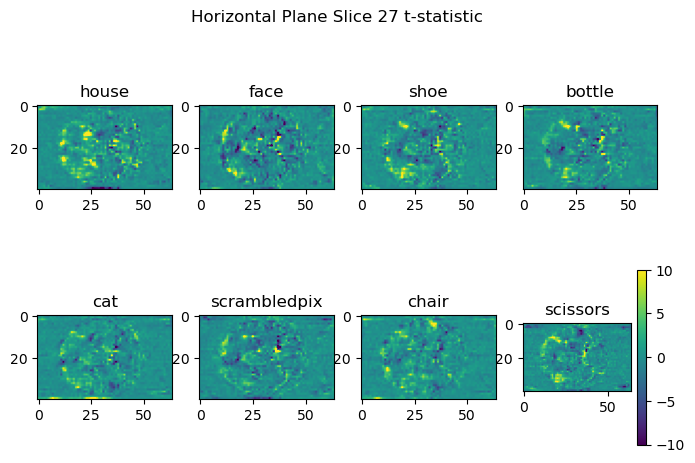

In [10]:
fig, axs = plt.subplots(2, 4)

for label, ax in zip(labels, axs.flat):
    ax.set_title(label)
    t_stats = t_dict[label]
    im = ax.imshow(t_stats[:, :, 27], vmin=-10, vmax=10)
    
    
fig.colorbar(im)
fig.suptitle("Horizontal Plane Slice 27 t-statistic")
fig.show()

# Project Work 2 <a class="anchor" id="project2"></a>
---
## Response Comparison

In [11]:
def cmp_response_vec(s_data, X=design_matrix, stim1="face", stim2="house"):
    cmap = np.zeros(s_data.shape[:-1])
    c = np.zeros(len(labels) + 12)
    c[labels.index(stim1)] = -1.
    c[labels.index(stim2)] = 1.
    
    s_data_2d = s_data.reshape(-1, s_data.shape[-1])
    betas_2d = np.linalg.pinv(X.T @ X) @ X.T @ s_data_2d.T
    betas = np.reshape(betas_2d, (c.size, 
                                  s_data.shape[0], 
                                  s_data.shape[1], 
                                  s_data.shape[2]))
    cov_X = np.linalg.pinv(X.T @ X)
    err_var = np.var(X @ betas_2d - s_data_2d.T)
    num = c @ betas_2d
    denom = np.sqrt(err_var * c @ cov_X @ c.T)
    cmp_map = np.reshape(num / denom, s_data.shape[:-1])
    
    return cmp_map

cmap_vec_face_house = cmp_response_vec(s1_data)
cmap_vec_scissor_cat = cmp_response_vec(s1_data, stim1="scissors", stim2="cat")

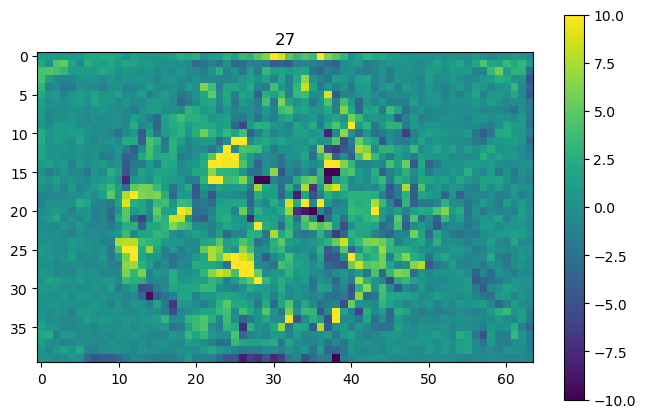

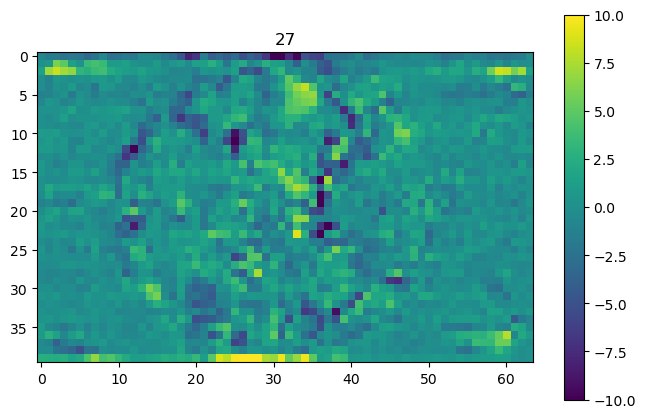

In [12]:
def plot_data(cmap_vec, slice_no=27):
    plt.imshow(cmap_vec[:, :, slice_no], vmin=-10, vmax=10)
    plt.colorbar()
    plt.title(slice_no)
    plt.show()
    
plot_data(cmap_vec_face_house)
plot_data(cmap_vec_scissor_cat)

## ROI Analysis

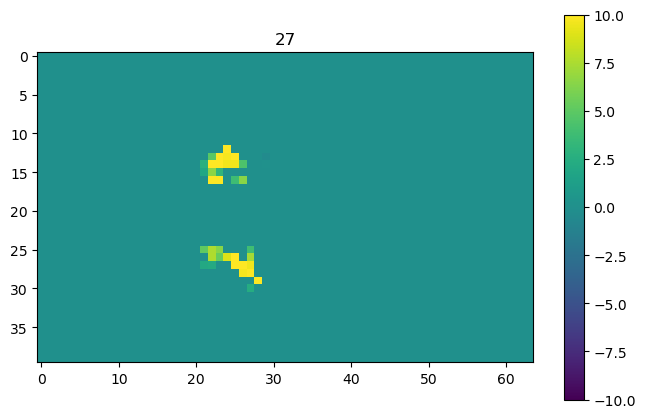

In [13]:
vt_mask = nib.load("subj1/mask8_house_vt.nii.gz").get_fdata()

def plot_data_masked(cmap_vec, slice_no=27):
    plt.imshow(cmap_vec[:, :, slice_no] * vt_mask[:, :, slice_no], vmin=-10, vmax=10)
    plt.colorbar()
    plt.title(slice_no)
    plt.show()
    
    
plot_data_masked(cmap_vec_face_house)

In [16]:
mask_expanded = np.repeat(np.expand_dims(vt_mask, -1), s1_data.shape[-1], axis=-1)
roi_data = s1_data * mask_expanded

<Figure size 1500x200 with 0 Axes>

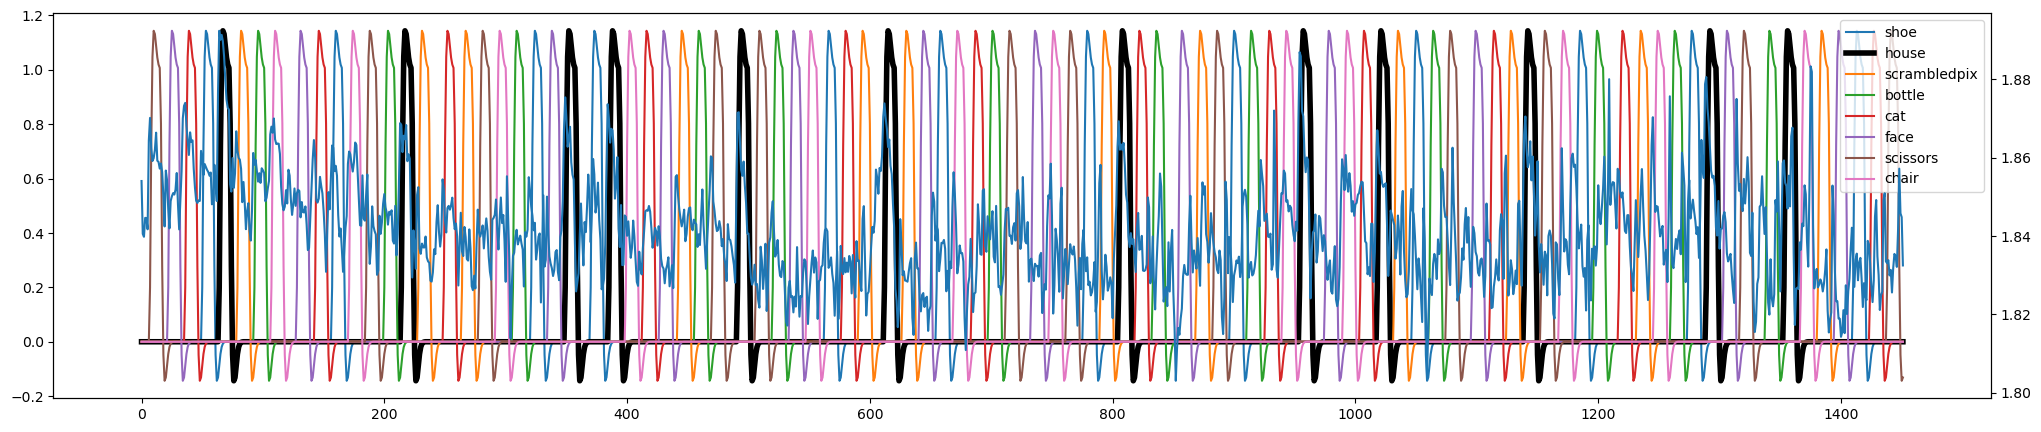

In [17]:
roi_avg = np.mean(roi_data.reshape(-1, 1452), axis=0)

plt.rcParams["figure.figsize"] = (25,5)
plt.figure(figsize=(15, 2))

fig, ax1 = plt.subplots()

for i in range(8):
    if labels[i] == "house":
        ax1.plot(design_matrix[:, i], c="k", linewidth=4)
    else:
        ax1.plot(design_matrix[:, i])

ax1.legend(labels, loc="upper right")
ax2 = ax1.twinx()

ax2.plot(roi_avg)

In [18]:
betas_dict["house"].shape
mask_expanded = np.repeat(np.expand_dims(vt_mask, 0), 20, axis=0)

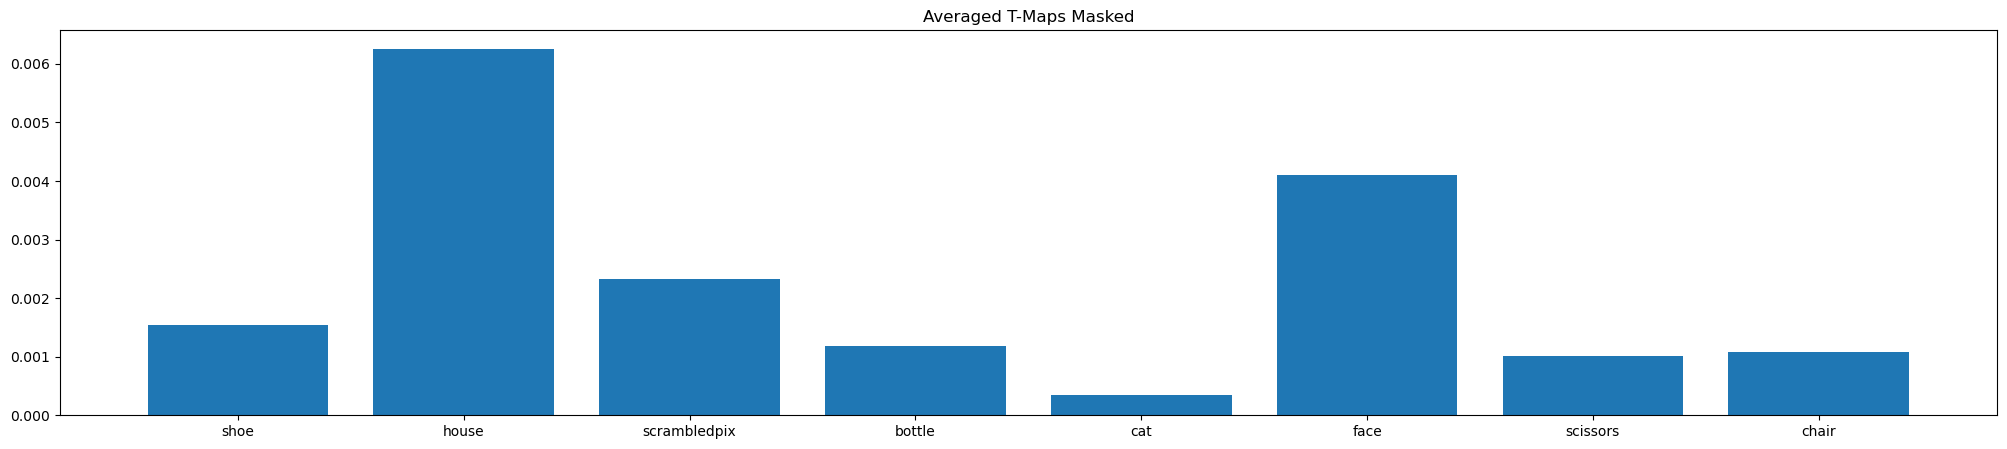

In [19]:
beta_means = [np.abs(np.mean(t_dict[label] * mask_expanded)) for label in labels]
    
plt.bar(labels, beta_means)
plt.title("Averaged T-Maps Masked")
plt.show()

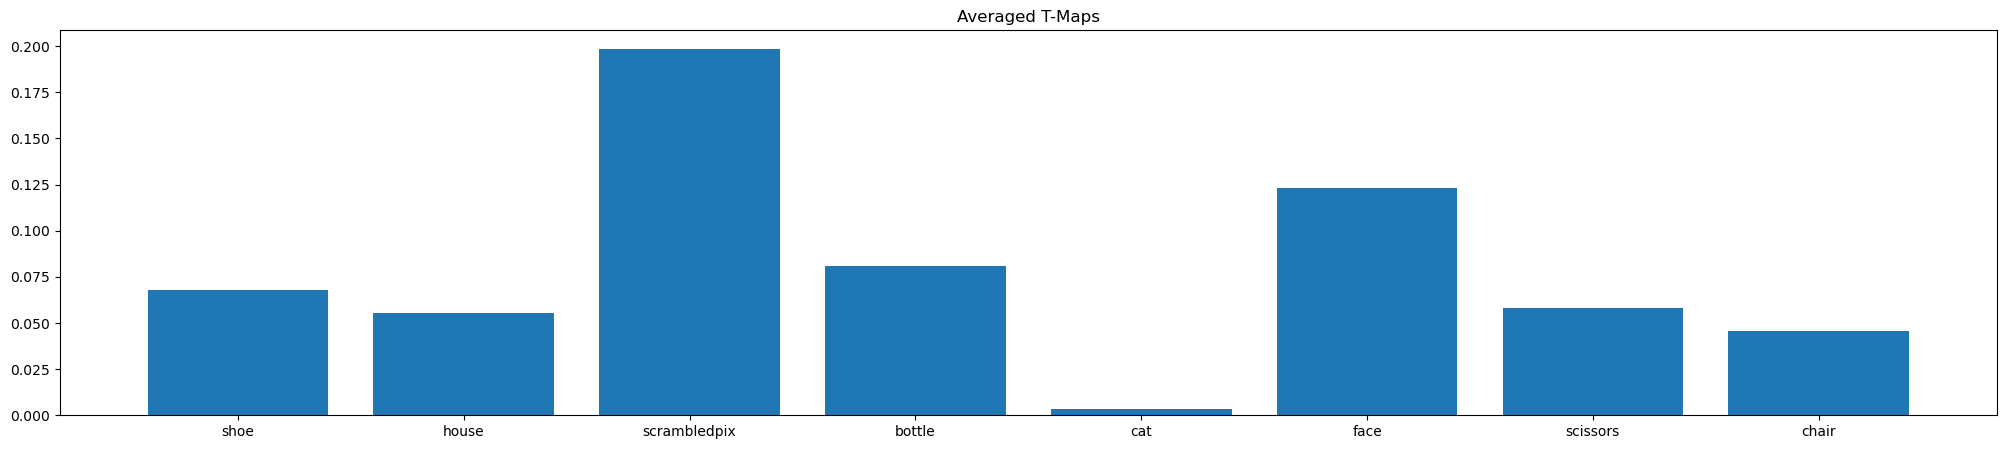

In [20]:
beta_means = [np.abs(np.mean(t_dict[label])) for label in labels]
    
plt.bar(labels, beta_means)
plt.title("Averaged T-Maps")
plt.show()

# Project Work 3 <a class="anchor" id="project3"></a>
---

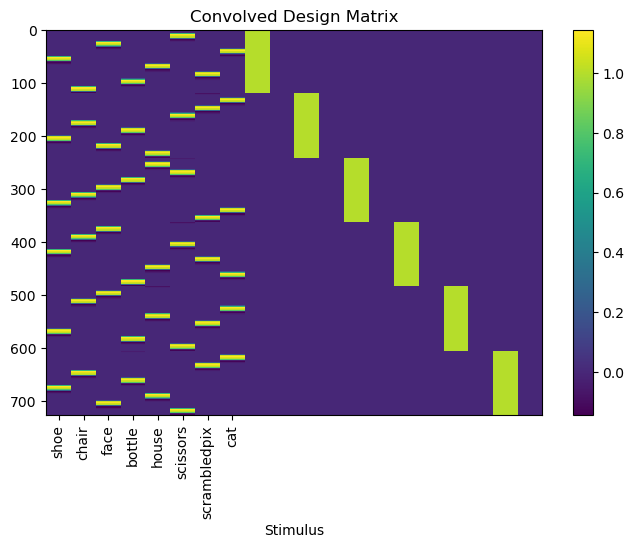

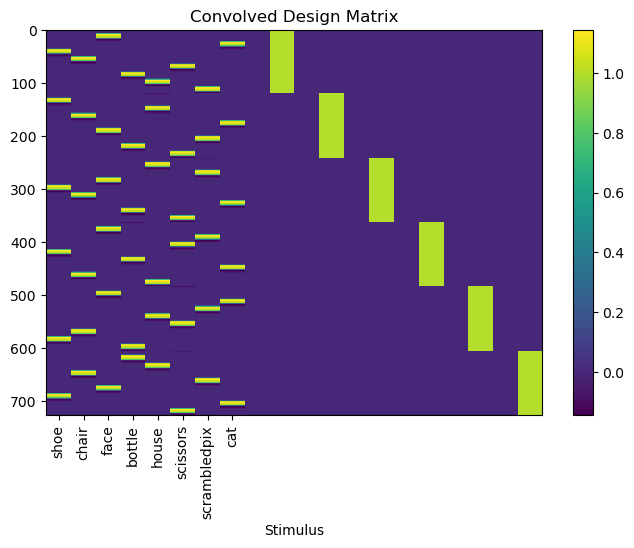

In [10]:
n = s1_data.shape[-1] // 12
train_data = np.concatenate([s1_data[:, :, :, i*n:(i + 1)*n] for i in range(0, 12, 2)], axis=-1)
test_data = np.concatenate([s1_data[:, :, :, i*n:(i + 1)*n] for i in range(1, 12, 2)], axis=-1)

train_dm = np.concatenate([design_matrix[i*n:(i+1)*n, :] for i in range(0, 12, 2)], axis=0)
test_dm = np.concatenate([design_matrix[i*n:(i+1)*n, :] for i in range(1, 12, 2)], axis=0)

plt.imshow(train_dm, aspect="auto", interpolation="none")
plt.xticks(np.arange(len(labels)), labels, rotation="vertical")
plt.xlabel("Stimulus")
plt.title("Convolved Design Matrix")
plt.colorbar()
plt.show()

plt.imshow(test_dm, aspect="auto", interpolation="none")
plt.xticks(np.arange(len(labels)), labels, rotation="vertical")
plt.xlabel("Stimulus")
plt.title("Convolved Design Matrix")
plt.colorbar()
plt.show()

In [24]:
vt_mask4 = nib.load("subj1/mask4_vt.nii.gz").get_fdata()

In [13]:
%time

def pattern_corr_classifier(train_data, train_dm, test_data, test_dm, labels=labels):
    correlations = dict()
    for label1 in labels:
        for label2 in labels:
            t_map1, _ = fit_glm_vec(train_data, X=train_dm, labels=labels, stimulus=label1)
            t_map2, _ = fit_glm_vec(test_data, X=test_dm, labels=labels, stimulus=label2)
            corr = np.corrcoef((t_map1 * vt_mask4).flatten(), (t_map2 * vt_mask4).flatten())[0, 1]
            print(label1, label2, corr, sep=" ")
            correlations[(label1, label2)] = corr
            
    return correlations
        
corr_dict = pattern_corr_classifier(train_data, train_dm, test_data, test_dm)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.8 µs
shoe shoe 0.7871601242389261
shoe chair 0.5710352311970175
shoe face 0.4602902852002739
shoe bottle 0.6166163980190235
shoe house 0.4700796952443828
shoe scissors 0.7577014986781693
shoe scrambledpix 0.4391517178579694
shoe cat 0.5821337741110889
chair shoe 0.7534434890022864
chair chair 0.7428016687226207
chair face -0.01931426184965987
chair bottle 0.47926616240553627
chair house 0.6193837768369324
chair scissors 0.5556375617748721
chair scrambledpix -0.05557267822862653
chair cat 0.661542519760707
face shoe 0.5015520449701847
face chair 0.25585423725291906
face face 0.4605505921152881
face bottle 0.4864441086686175
face house 0.10655374549987438
face scissors 0.42450643130698956
face scrambledpix 0.37687949134018717
face cat 0.4462838422179405
bottle shoe 0.7045631269856396
bottle chair 0.5626403879240759
bottle face 0.4685926899161937
bottle bottle 0.5405421997679742
bottle house 0.4480686608523117
bottle scissors 0.67

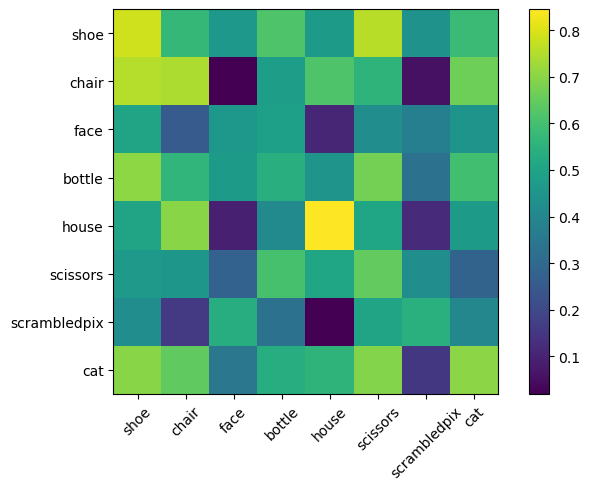

In [33]:
corrs = np.zeros((8, 8))

for k, v in corr_dict.items():
    corrs[labels.index(k[0]), labels.index(k[1])] = v
    
plt.imshow(np.abs(corrs))
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.colorbar()
plt.show()

/tmp/ipykernel_16012/2276081231.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 45)


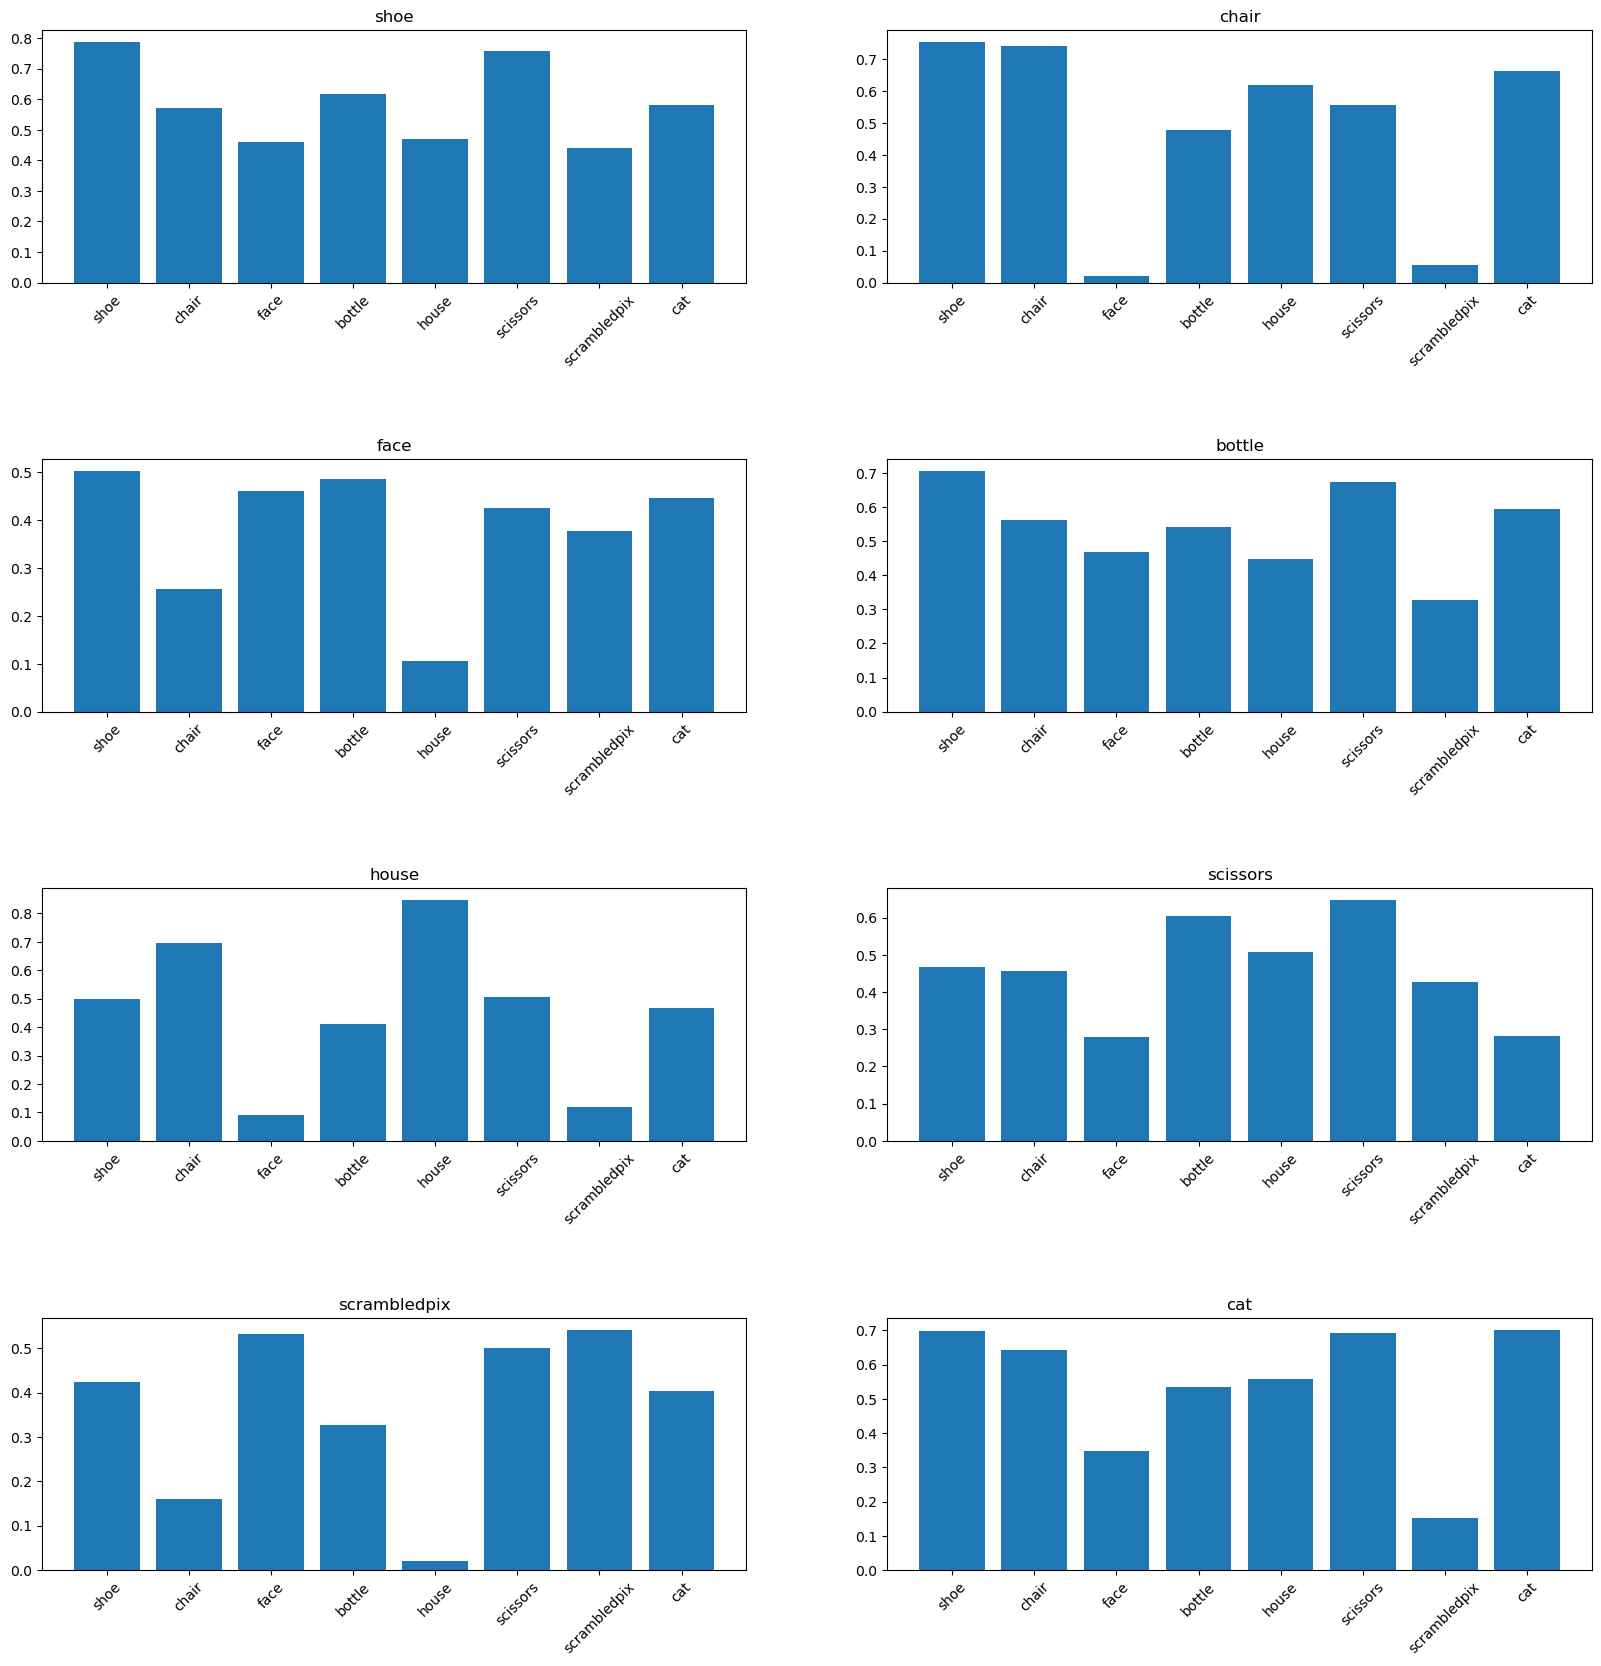

In [63]:
plt.rcParams["figure.figsize"] = (20, 20)
fig, axs = plt.subplots(4, 2)
for label, ax in zip(labels, axs.flat):
    ax.bar(labels, np.abs(list(corr_dict.values())[labels.index(label) * 8:labels.index(label) * 8 + 8]))
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_title(label)
    
fig.subplots_adjust(hspace=.7)
plt.show()

# Project Work 4 <a class="anchor" id="project4"></a>
---

In [14]:
face_mask = nib.load("subj1/mask8_face_vt.nii.gz").get_fdata()

def compute_rdm_roi(s_data, mask, dm=design_matrix, labels=labels):
    dists = dict()
    for label1 in labels:
        for label2 in labels:
            t_map1, _ = fit_glm_vec(s_data, X=dm, labels=labels, stimulus=label1)
            t_map2, _ = fit_glm_vec(s_data, X=dm, labels=labels, stimulus=label2)
            dist = 1. - np.abs(np.corrcoef((t_map1 * mask).flatten(), (t_map2 * mask).flatten())[0, 1])
            print(label1, label2, dist, sep=" ")
            dists[(label1, label2)] = dist
            
    return dists

distances_roi_face = compute_rdm_roi(s1_data, face_mask)

house house 1.1102230246251565e-16
house face 0.6228776103406477
house shoe 0.4512719804907701
house bottle 0.296625358731359
house cat 0.7238543019899488
house scrambledpix 0.9887398036065425
house chair 0.7242017423860964
house scissors 0.5035506350657314
face house 0.6228776103406478
face face 0.0
face shoe 0.3985131371891023
face bottle 0.21889172818916258
face cat 0.10915098258089073
face scrambledpix 0.7630980839946857
face chair 0.593043980774854
face scissors 0.2439002510743441
shoe house 0.45127198049077
shoe face 0.3985131371891023
shoe shoe 0.0
shoe bottle 0.2748673158504952
shoe cat 0.6905795961468937
shoe scrambledpix 0.943308851843239
shoe chair 0.5832299517729661
shoe scissors 0.2551946504963325
bottle house 0.296625358731359
bottle face 0.2188917281891627
bottle shoe 0.2748673158504953
bottle bottle 0.0
bottle cat 0.3793394027948228
bottle scrambledpix 0.9861002857889672
bottle chair 0.8402880399557986
bottle scissors 0.18773024249505466
cat house 0.7238543019899488
cat

In [15]:
distances_roi_house = compute_rdm_roi(s1_data, vt_mask)

house house 1.1102230246251565e-16
house face 0.4350604365344357
house shoe 0.9080540436377829
house bottle 0.8573138212236646
house cat 0.9287776317652368
house scrambledpix 0.5698484368996422
house chair 0.4449332896738656
house scissors 0.9260909938460002
face house 0.4350604365344357
face face 1.1102230246251565e-16
face shoe 0.382939221563232
face bottle 0.3984112535255323
face cat 0.5958262206006234
face scrambledpix 0.19857507266660923
face chair 0.9236342272718655
face scissors 0.5091139021754605
shoe house 0.9080540436377829
shoe face 0.382939221563232
shoe shoe 0.0
shoe bottle 0.18066086021793404
shoe cat 0.4486746802352781
shoe scrambledpix 0.3280206158014103
shoe chair 0.47409557826063276
shoe scissors 0.28481553061462905
bottle house 0.8573138212236646
bottle face 0.3984112535255323
bottle shoe 0.18066086021793404
bottle bottle 1.1102230246251565e-16
bottle cat 0.4298592787693495
bottle scrambledpix 0.31868535351231586
bottle chair 0.5051615783847918
bottle scissors 0.2900

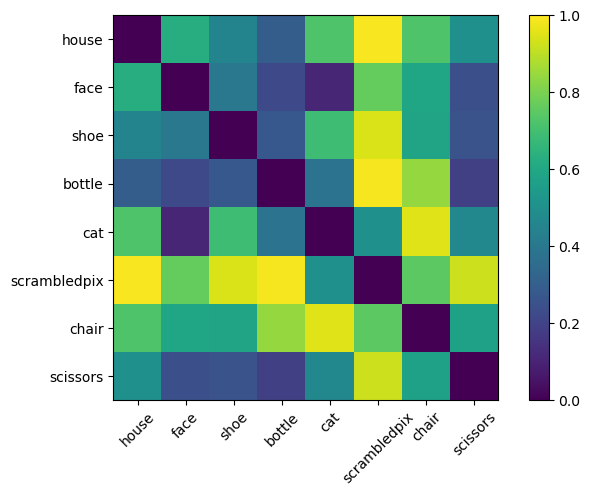

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-01/2eea7963/lib/python3.10/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-01/2eea7963/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


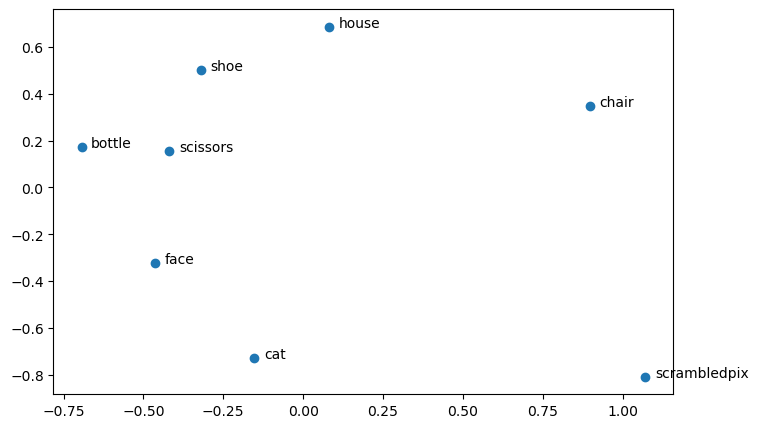

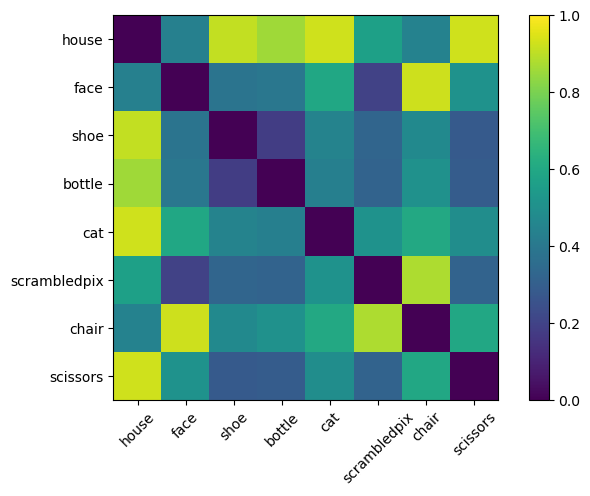

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-01/2eea7963/lib/python3.10/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-01/2eea7963/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


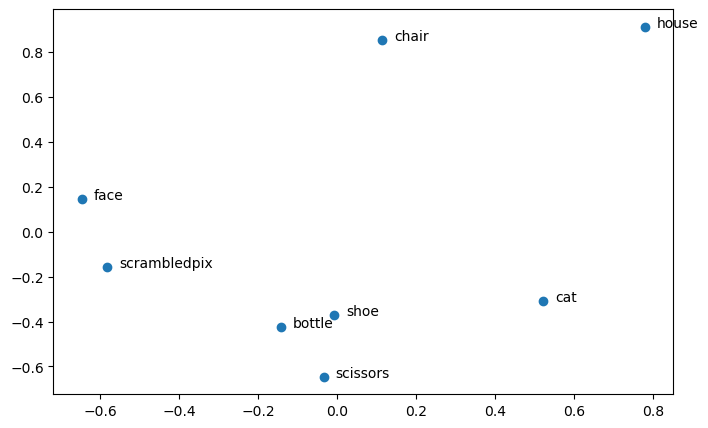

In [41]:
from sklearn.manifold import MDS

dists = np.zeros((8, 8))

for k, v in distances_roi_face.items():
    dists[labels.index(k[0]), labels.index(k[1])] = v
    
plt.imshow(np.abs(dists), vmin=0, vmax=1)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.colorbar()
plt.show()

mds = MDS()

scaled_rdm = mds.fit_transform(dists)

plt.scatter(scaled_rdm[:, 0], scaled_rdm[:, 1])
for i, txt in enumerate(labels):
    plt.annotate(txt, (scaled_rdm[:, 0][i]+.03, scaled_rdm[:, 1][i]))
    
plt.show()

dists = np.zeros((8, 8))

for k, v in distances_roi_house.items():
    dists[labels.index(k[0]), labels.index(k[1])] = v
    
plt.imshow(np.abs(dists), vmin=0, vmax=1)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.colorbar()
plt.show()

mds = MDS()

scaled_rdm = mds.fit_transform(dists)

plt.scatter(scaled_rdm[:, 0], scaled_rdm[:, 1])
for i, txt in enumerate(labels):
    plt.annotate(txt, (scaled_rdm[:, 0][i]+.03, scaled_rdm[:, 1][i]))
    
plt.show()